# 1. Import lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

# 2. EDA

Fitler all null CustomerID. Null CustomerID give us no data about transaction, can make noise

In [2]:
df = pd.read_csv("raw_data.csv", dtype = {'CustomerID': str, 'InvoiceNo': str,'StockCode':str})
df = df[~df['CustomerID'].isna()]

In [6]:
df = pd.read_csv("raw_data.csv", dtype = {'CustomerID': str, 'InvoiceNo': str,'StockCode':str})
df.notna().sum()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

## 2.1 By region

<AxesSubplot:xlabel='Country'>

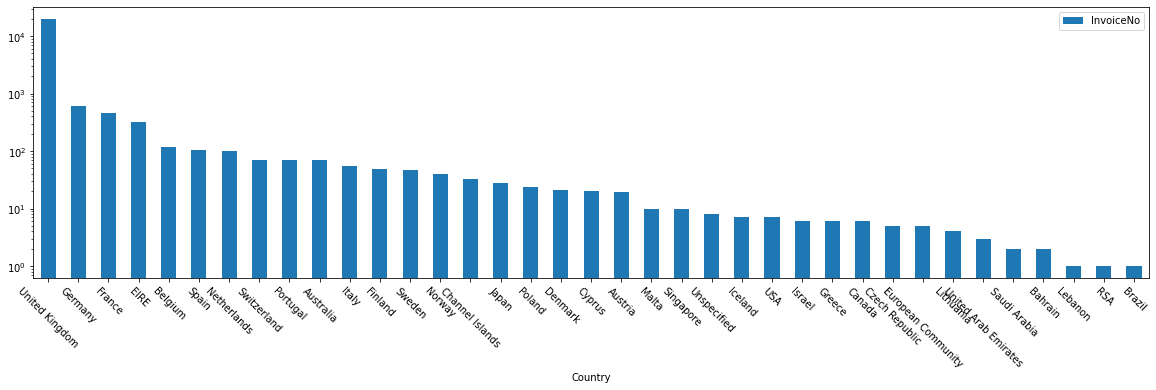

In [45]:
df.groupby('Country').agg({'InvoiceNo':'nunique'}).reset_index().set_index(['Country']).sort_values('InvoiceNo',ascending=False).plot(kind='bar',logy=True,figsize=(20,5),rot=-45)

In [46]:
df.groupby('Country').agg({'InvoiceNo':'nunique'}).reset_index().sort_values('InvoiceNo',ascending=False).reset_index(drop=True)

,Country,InvoiceNo
0,United Kingdom,19857
1,Germany,603
2,France,458
3,EIRE,319
4,Belgium,119
5,Spain,105
6,Netherlands,101
7,Switzerland,71
8,Portugal,70
9,Australia,69


## 2.2 Quantity group by StockCode

In [7]:
quantity = df.groupby('StockCode').agg({'Quantity':'sum'}).reset_index().sort_values('Quantity',ascending=False)
quantity.head(10)

,StockCode,Quantity
1147,22197,56450
2997,84077,53847
3515,85099B,47363
3536,85123A,38830
3305,84879,36221
454,21212,36039
1982,23084,30646
1412,22492,26437
1530,22616,26315
966,21977,24753


I have the assumption : negative quantity for each StockCode can be failed transaction

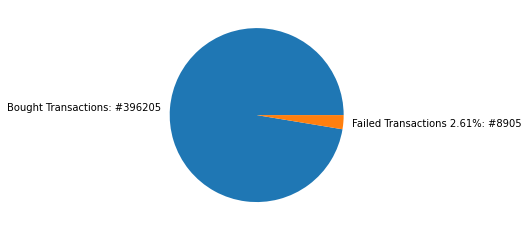

In [49]:
num_fail = len(df[df.Quantity < 0])
buy_transaction = len(df) - num_cancell
fail_rate = round(num_cancell / len(df) * 100, 2)

fig, ax = plt.subplots()
ax.pie(
    [buy_transaction, num_cancell],
    labels=(f'Bought Transactions: #{buy_transaction}',f'Failed Transactions {fail_rate}%: #{num_fail}')
)
plt.show()


Failed rate is about 2.61% , it's normal when compare with the failed transaction in ecommerce . I think my assumption is right

## 2.3 Monetary analysis


About failed transaction, I think in the recommendation engine, it's not take any effect, included these data can make noise for building the engine

In [51]:
df = df[df.Quantity > 0]

### 2.3.1 GMV per CustomerID

<AxesSubplot:ylabel='Frequency'>

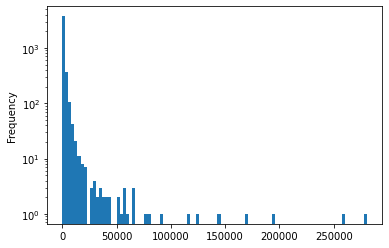

In [52]:
tmp = df.copy()
features = df.drop_duplicates('CustomerID')[['CustomerID']]
tmp['TotalSale'] = tmp['Quantity']*tmp['UnitPrice']
gmv = tmp.groupby('CustomerID').agg({'TotalSale':'sum'}).reset_index()

features = pd.merge(features,gmv,on='CustomerID')
features.TotalSale.plot(logx=False,logy=True,kind='hist',bins=100)

In [55]:
features.TotalSale.describe()

count      4339.000000
mean       2053.793018
std        8988.248381
min           0.000000
25%         307.245000
50%         674.450000
75%        1661.640000
max      280206.020000
Name: TotalSale, dtype: float64

### 2.3.2 AOV per CustomerID

<AxesSubplot:ylabel='Frequency'>

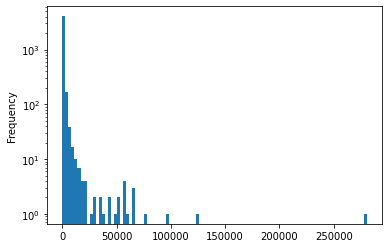

In [53]:
features['Aov'] = features['TotalSale'] / tmp.groupby('CustomerID').agg({'InvoiceNo':'nunique'}).reset_index()['InvoiceNo']
features.Aov.plot(logx=False,logy=True,kind='hist',bins=100)

In [56]:
features.Aov.describe()

count      4339.000000
mean       1135.047993
std        6176.162772
min           0.000000
25%         100.955000
50%         280.883333
75%         774.770000
max      280206.020000
Name: Aov, dtype: float64

### 2.3.3 Number Order

<AxesSubplot:ylabel='Frequency'>

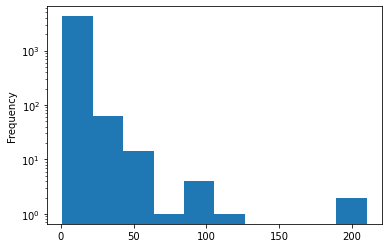

In [59]:
df.groupby('CustomerID').agg({'InvoiceNo':'nunique'}).reset_index().InvoiceNo.plot(kind='hist',logy=True)

In [60]:
df.groupby('CustomerID').agg({'InvoiceNo':'nunique'}).reset_index().InvoiceNo.describe()

count    4339.000000
mean        4.271952
std         7.705493
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       210.000000
Name: InvoiceNo, dtype: float64

- When see in the histogram of GMV each CustomerID, I see plot is skewed into range 0-50000. 
- When see in the plot and describe data of number order each CustomerID, I see 75% number order less than 5, I have no data about datetime, so I guess the data prolonged 4-5 months

Conclusion, I think every user who has GMV more than 50000 dollars (or euros) can be business (due to large GMV), not customer, so I remove all CustomerID who has more than 50k GMV, casue the behavior in B2B is diffirent with B2C 